# 顔文字生成器（サンプル）
単純ニューラルネットワークだけのシンプル構成  
系列データを1次元にまとめて計算させる

In [1]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=edc837f2398ac09f8be0edfe0a7543e064e364337aeb1796909458f612d09278
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

from sklearn.manifold import TSNE

## 前処理

### データ読み込み

In [3]:
# 特殊文字
sp = {'pad': '<PAD>',
      # 'bos': '<BOS>',
      # 'eos': '<EOS>',
      'unk': '<UNK>'}
# pad : padding. 文字列長を一定にするために使う
# bos : begin of sequence. 文頭文字．Decoderの最初の入力
# eos : end of sequence. 文末文字．
# unk : unknown. 出現数が低いものに割り当てる

In [4]:
sp.values()

dict_values(['<PAD>', '<UNK>'])

In [5]:
KAOMOJI_MAX = 10    # 顔文字最大長

kmj_list = []   # 顔文字リスト
len_list = []       # <BOS> から <EOS> までの文字数のリスト
char_list = []      # 顔文字に使用されている文字のリスト

char_list += list(sp.values())
file_name = 'kaomoji_MAX=' + str(KAOMOJI_MAX) + '_DA.txt'

with open(file_name, mode='r') as file:
  for line in file:
    # temp = [sp['bos']]
    temp = list(line.replace('\n', ''))
    # temp += [sp['eos']]
    len_list.append(len(temp))
    temp += [sp['pad'] for _ in range(KAOMOJI_MAX - len(temp))]
    kmj_list.append(temp)
    char_list += temp

# 重複を消す
char_list = sorted(set(char_list), key=char_list.index)

In [6]:
print(kmj_list[0])

['(', '’', '⌒', '’', ')', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [7]:
print('Number of kaomoji  :', len(kmj_list))
print('Number of character:', len(char_list))

Number of kaomoji  : 10300
Number of character: 719


### 出現数が少ないものを置換

In [8]:
# 最小出現数
MIN_APPEAR = 20

kmj_list = np.array(kmj_list)

cnt = 0
for c in char_list:
  mask = (kmj_list == c)
  if np.sum(mask) < MIN_APPEAR:
    kmj_list[mask] = sp['unk']

char_list = list(sp.values()) + kmj_list.flatten().tolist()
char_list = sorted(set(char_list), key=char_list.index)

In [9]:
print('Number of character:', len(char_list))

Number of character: 200


### 添字検索
顔文字に使われる文字が文字リストの何番目にあるか調べる

In [10]:
kmj_index = []    # 添字リスト

for kmj in kmj_list.tolist():
  temp = [char_list.index(c) for c in kmj]
  kmj_index.append(temp)

In [11]:
print(len_list[0])
kmj_index[0]

5


[2, 3, 4, 3, 5, 0, 0, 0, 0, 0]

### One-hotベクトル化



In [12]:
kmj_num = len(kmj_index)        # 顔文字の総数
kmj_size = len(kmj_index[0])    # 1つの顔文字の長さ
char_num = len(char_list)       # 文字の種類数

# One-hotベクトルリスト
kmj_onehot = np.zeros((kmj_num, kmj_size, char_num))

for i, index in enumerate(kmj_index):
  mask = range(char_num) == np.array(index).reshape((kmj_size, 1))
  kmj_onehot[i][mask] = 1

In [13]:
kmj_onehot.shape

(10300, 10, 200)

### 訓練・検証・テスト用に分ける

In [14]:
dataset = torch.utils.data.TensorDataset(
  torch.tensor(kmj_onehot.astype('float32')),
  torch.tensor(len_list)
)

In [15]:
train_size = int(len(dataset) * 0.85)
valid_size = int(len(dataset) * 0.10)
test_size  = len(dataset) - train_size - valid_size

# indices = np.arange(len(dataset))

# dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
# dataset_valid = torch.utils.data.Subset(dataset, indices[train_size:train_size+valid_size])
# dataset_test  = torch.utils.data.Subset(dataset, indices[train_size+valid_size:])

split = [train_size, valid_size, test_size]

dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, split)

In [16]:
dataset_train[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(10))

In [17]:
batch_size = 128

dataloader_train = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
  dataset_valid,
  batch_size=batch_size,
  shuffle=True
)

In [18]:
for x, len_seq in dataloader_train:
  print(x.shape, len_seq.shape)
  break

torch.Size([128, 10, 200]) torch.Size([128])


## モデル

### Encoder

In [19]:
class Encoder(nn.Module):
  def __init__(self, N, in_dim, emb_dim, hid_dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(in_dim, emb_dim),
      # nn.Sigmoid(),
      nn.Flatten(),
      nn.Linear(N*emb_dim, hid_dim),
      # nn.Sigmoid()
    )

  def forward(self, x):
    return self.net(x)

In [20]:
encoder = Encoder(20, 269, 16, 64)
x = torch.rand(32, 20, 269)
encoder(x).shape

torch.Size([32, 64])

### Decoder

In [21]:
class Decoder(nn.Module):
  def __init__(self, in_dim, hid_dim, out_dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(in_dim, hid_dim),
      nn.Sigmoid(),
      # nn.Linear(hid_dim, hid_dim),
      # nn.ReLU(),
      nn.Linear(hid_dim, out_dim),
    )

  def forward(self, x):
    return self.net(x)

In [22]:
decoder = Decoder(64, 64, 20*269)
x = torch.rand(32, 64)
decoder(x).shape

torch.Size([32, 5380])

### Generator

In [23]:
class Generator(nn.Module):
  def __init__(self, N, in_dim, emb_dim, hid_dim):
    super().__init__()
    self.N = N
    self.in_dim = in_dim
    self.encoder = Encoder(N, in_dim, emb_dim, hid_dim)
    self.decoder = Decoder(hid_dim, hid_dim, N*in_dim)

  def forward(self, x):
    z = self.encoder(x)
    y = self.decoder(z)
    return y.view(-1, self.N, self.in_dim)

In [24]:
generator = Generator(20, 269, 16, 64)
x = torch.rand(32, 20, 269)
generator(x).shape

torch.Size([32, 20, 269])

## 学習

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
n_epochs = 50

N = KAOMOJI_MAX
in_dim = len(char_list)
emb_dim = 16
hid_dim = 128

net = Generator(N, in_dim, emb_dim, hid_dim)

optimizer = optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [27]:
for epoch in range(n_epochs):
  losses_train = []
  losses_valid = []
  acc_train = 0
  acc_valid = 0

  # 訓練
  net.train()
  for x, len_seq in dataloader_train:
    net.zero_grad()  # 勾配の初期化

    #x.to(device)
    #t.to(device)

    y = net(x)

    loss = criterion(y, x)
    acc_train += (y.argmax(dim=2) == x.argmax(dim=2)).sum()
    loss.backward()  # 誤差の逆伝播
    losses_train.append(loss.tolist())

    optimizer.step()  # パラメータの更新

  # 検証
  net.eval()
  for x, len_seq in dataloader_valid:
    y = net(x)

    loss = criterion(y, x)
    acc_valid += (y.argmax(dim=2) == x.argmax(dim=2)).sum()
    losses_valid.append(loss.tolist())

  if (epoch+1) % 5 == 0:
    print('EPOCH: {:>3}, Train Loss: {:>4.5f}  Acc: {:>.3f},    Valid Loss: {:>4.5f}  Acc: {:>.3f}'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train / (train_size * N),
        np.mean(losses_valid),
        acc_valid / (valid_size * N)
    ))

EPOCH:   5, Train Loss: 0.03442  Acc: 0.542,    Valid Loss: 0.04004  Acc: 0.542
EPOCH:  10, Train Loss: 0.02734  Acc: 0.581,    Valid Loss: 0.03541  Acc: 0.571
EPOCH:  15, Train Loss: 0.02579  Acc: 0.595,    Valid Loss: 0.03832  Acc: 0.575
EPOCH:  20, Train Loss: 0.02530  Acc: 0.593,    Valid Loss: 0.03766  Acc: 0.573
EPOCH:  25, Train Loss: 0.02511  Acc: 0.591,    Valid Loss: 0.03628  Acc: 0.561
EPOCH:  30, Train Loss: 0.02493  Acc: 0.591,    Valid Loss: 0.03772  Acc: 0.569
EPOCH:  35, Train Loss: 0.02504  Acc: 0.582,    Valid Loss: 0.03761  Acc: 0.554
EPOCH:  40, Train Loss: 0.02498  Acc: 0.576,    Valid Loss: 0.03611  Acc: 0.552
EPOCH:  45, Train Loss: 0.02497  Acc: 0.567,    Valid Loss: 0.03884  Acc: 0.545
EPOCH:  50, Train Loss: 0.02492  Acc: 0.563,    Valid Loss: 0.04079  Acc: 0.535


## 評価

In [28]:
def convert_str(x):
  x = np.array(char_list)[x.argmax(dim=1)]
  x = [c for c in x if c not in sp.values()]

  return ''.join(x)

def generate(net, base=None, rate=3.0):
  if base is None:
    z = 2*rate * torch.randn(1, hid_dim) - rate
  else:
    z = net.encoder(base.unsqueeze(0))
    eps = 2*rate * torch.rand(1, hid_dim) - rate
    z = z + eps

  y = net.decoder(z)
  gen = convert_str(y.view(KAOMOJI_MAX, len(char_list)))

  return ''.join(gen)

### 次元圧縮テスト
目標はbaseとgenerateで全く同じもの．
次元圧縮して，潜在ベクトルが獲得できているかどうかのテスト．

In [29]:
for i in np.random.randint(0, len(dataset_test), size=10):
  test = dataset_test[i][0]
  print('base     :', convert_str(test))
  print('generate :', generate(net, base=test, rate=0.0))

base     : ・・・(　Дヾ　)
generate : 】♪シ(　∀ω┃)
base     : (*́　ε゚*)
generate : (*́　∀≦;)
base     : ??(°□。)
generate : ✧ヾ(≧∀≦)
base     : Σ(゚Д゚;!
generate : ヽ(≧ω≦;!
base     : (o;TωT)o"!
generate : (/*≧∀<)ノ【
base     : ∋_〆(∀`●)
generate : ♪(#(Д`;)
base     : (、>ω<)
generate : (メ>∀≦)─
base     : ;;;..)〆__
generate : o;;>-)/\
base     : ♪(　v'●)ヽ
generate : ♪(>Д≦*)┌
base     : ヾ(・・　)
generate : σ(≧.　)


### 生成テスト
潜在ベクトルに乱数を入力しその出力を見る．

In [34]:
for _ in range(10):
  print('generate :', generate(net, base=None, rate=10.0))

generate : (`ω　u)ノ!
generate : ((*O　́　)
generate : ((　>∇<))♪
generate : (ヾ(з^))!
generate : (　ωc)!
generate : (;́⌒∀^!
generate : ☆((▼　))
generate : ((д́　)))
generate : (╬`ω　・́!
generate : ((꒪∀^́))


### 類似度テスト
訓練データの中から潜在ベクトルの距離が近いものを見る．

In [36]:
def similar(net, base, num=10):
  z = net.encoder(base.unsqueeze(0))

  size = list(z.shape)
  size[0] = 0
  z_list = torch.empty(size, dtype=torch.float)
  z_list = net.encoder(dataset_train[:][0])

  diff = z_list - z
  norm = enumerate(torch.norm(diff, dim=1))
  norm = sorted(norm, key=lambda x: x[1])

  for i in range(num):
    min_index = norm[i][0]
    str = convert_str(dataset_train[min_index][0])
    print('{} : {}'.format(str, norm[i][1]))

In [79]:
i = np.random.randint(0, len(dataset_test))
test = dataset_test[i][0]
print(convert_str(test), ' : base')
similar(net, test, num=10)

(`エ　́*)  : base
(`ー　́〃) : 4.395081996917725
(`-　́メ) : 4.6557183265686035
(*✧×✧*) : 6.670565605163574
(`∇　́)♪ : 6.847037315368652
(`3　́) : 6.957399368286133
(`д　́)! : 6.979678153991699
(`　́)! : 6.996184825897217
(*≧m≦*) : 6.998400688171387
(`Д　́)! : 7.00465726852417
(艸Д　゚*) : 7.039266586303711


### 潜在ベクトルの分布図
t-SNEという次元削減アルゴリズムがあるらしいので，それを使って潜在ベクトルを2次元化して表示

In [80]:
z_list = net.encoder(dataset_train[:][0]).detach().numpy()
z_reduc = TSNE(n_components=2).fit_transform(z_list).T

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 42154 (\N{YI RADICAL JJUT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


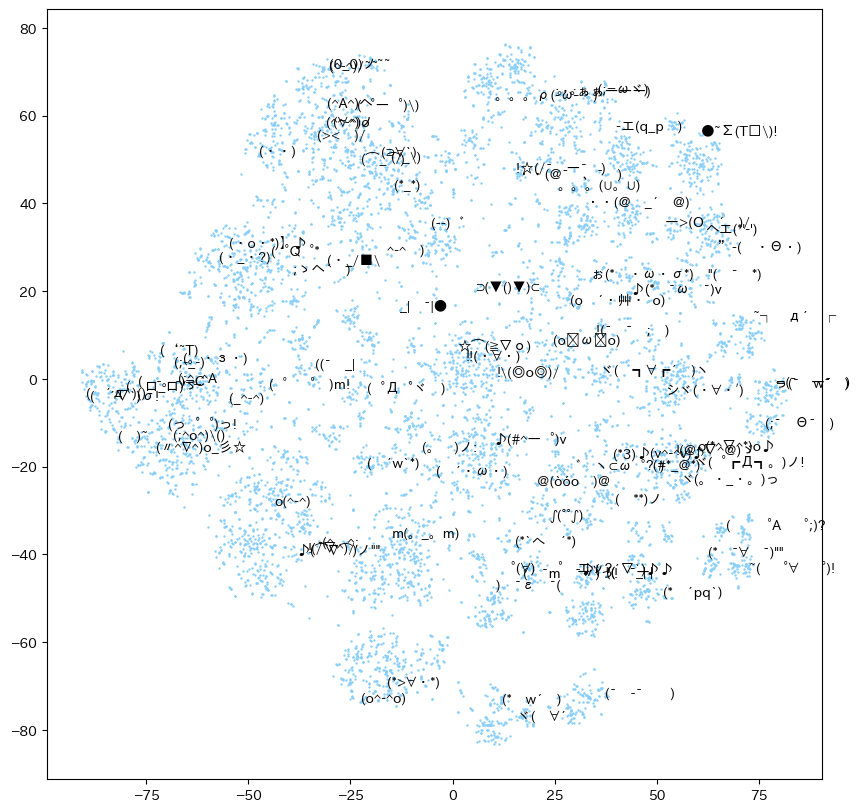

In [81]:
plt.figure(figsize=(10, 10))
plt.scatter(*z_reduc, s=0.5, c='lightskyblue')

for i in random.sample(range(len(dataset_train)), 100):
  plt.text(*z_reduc[:, i], convert_str(dataset_train[i][0]), fontsize=10)

plt.show()

## 感想

このネットワークは，  
Encoder：Embedding+Flatten+Linear  
Decoder：Linear  
の構成

入力系列のそれぞれのEmbeddingを無理矢理，平坦化して計算させる．

活性化関数はない方が良い？

体感，LSTMよりも性能が良さげ

